In [5]:
import glob
import os
import subprocess
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mintpy import view, plot_network
from mintpy.objects import gnss, timeseries, ifgramStack
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, utils as ut
from scipy import signal

from urllib.request import urlretrieve
from matplotlib.backends.backend_pdf import PdfPages

In [11]:
def get_corners(atr):
    """Get corners coordinate."""
    length = int(atr['LENGTH'])
    width = int(atr['WIDTH'])
    W = float(atr['X_FIRST'])
    N = float(atr['Y_FIRST'])
    lon_step = float(atr['X_STEP'])
    lat_step = float(atr['Y_STEP'])
    S = N + lat_step * length
    E = W + lon_step * width

    return S, N, W, E, width, length
insar_velocity1,atr1 = readfile.read(r'C:\Users\bvarugu\Documents\Concord\Asc\velocity_refP725_msk_20alks_20rlks.h5', datasetName='velocity');
insar_velocity2,atr2 = readfile.read(r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\velocity_refMRRY_msk_20alks_20rlks.h5', datasetName='velocity');
insar_velocity1_RMSE = readfile.read(r'C:\Users\bvarugu\Documents\Concord\Asc\velocity_GNSS_msk_20alks_20rlks.h5', datasetName='velocityStd')[0];
insar_velocity2_RMSE = readfile.read(r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\velocity_GNSS_integrated_msk_20alks_20rlks.h5', datasetName='velocityStd')[0];



In [15]:
ratio_x = abs((float(atr1['X_STEP']) - float(atr2['X_STEP'])) / float(atr1['X_STEP']))
ratio_y = abs((float(atr1['Y_STEP']) - float(atr2['Y_STEP'])) / float(atr1['Y_STEP']))
if any(i > 1e-3 for i in [ratio_x, ratio_y]):
    print('file 1: X_STEP - {}, Y_STEP - {}'.format(atr1['X_STEP'], atr1['Y_STEP']))
    print('file 2: X_STEP - {}, Y_STEP - {}'.format(atr2['X_STEP'], atr2['Y_STEP']))
    print('rescale the 2nd matrix into the same spatial resolution as the 1st one ...')
    mat2, atr2 = rescale_data(mat2, meta=atr2, ref_meta=atr1)

# input spatial extents
print('grab corners of input matrices')
S1, N1, W1, E1, width1, length1 = get_corners(atr1)
S2, N2, W2, E2, width2, length2 = get_corners(atr2)
print(S1, N1, W1, E1, width1, length1);
print(S2, N2, W2, E2, width2, length2);
# output spatial extent
print('calculate corners of output matrix')
W, E = min(W1, W2), max(E1, E2)
S, N = min(S1, S2), max(N1, N2)
print(S,N,W,E)
lon_step = float(atr1['X_STEP'])
lat_step = float(atr1['Y_STEP'])
width  = int(np.ceil((E - W) / lon_step))
length = int(np.ceil((S - N) / lat_step))
print('Combined matrix shape is:',length,width)


grab corners of input matrices
35.586652432 37.403318372 -121.670784665 -118.504119265 190 109
34.42498623 36.24165217 -121.390784777 -118.24078603699999 189 109
calculate corners of output matrix
34.42498623 37.403318372 -121.670784665 -118.24078603699999
Combined matrix shape is: 179 206


In [19]:
# index of input matrices in output matrix
print('estimate difference in the overlapping area')
lon_seq = np.linspace(W, W + width  * lon_step, width, endpoint=False);
lat_seq = np.linspace(N, N + length * lat_step, length, endpoint=False);
lons,lats= np.meshgrid(lon_seq,lat_seq);
x1, y1 = np.argmin(np.square(lon_seq - W1)), np.argmin(np.square(lat_seq - N1))
x2, y2 = np.argmin(np.square(lon_seq - W2)), np.argmin(np.square(lat_seq - N2))
print(x1,y1,x1+width1,y1+length1)
print(x2,y2,x2+width2,y2+length2)
# estimate offset of the overlapping area
mat11 = np.zeros([length, width]) * np.nan;
mat22 = np.zeros([length, width]) * np.nan;
mat11[y1:y1+length1, x1:x1+width1] = insar_velocity1
mat22[y2:y2+length2, x2:x2+width2] = insar_velocity2
mat_diff = mat22 - mat11  ###the finite or non-nan values in this matrix correspond to the overlap area


def get_combined_mat(length, width,x1,y1,x2,y2,mat1,mat2,fill_value=np.nan):
    mat = np.zeros([length, width], dtype=mat1.dtype) * fill_value

    # fill the output matrix
    flag2 = np.isfinite(mat2)
    mat[y1:y1+length1, x1:x1+width1] = mat1
    mat[y2:y2+length2, x2:x2+width2][flag2] = mat2[flag2]
    return mat
combined_rmse = get_combined_mat(length,width,x1,y1,x2,y2,insar_velocity1_RMSE,insar_velocity2_RMSE)


estimate difference in the overlapping area
0 0 190 109
17 70 206 179


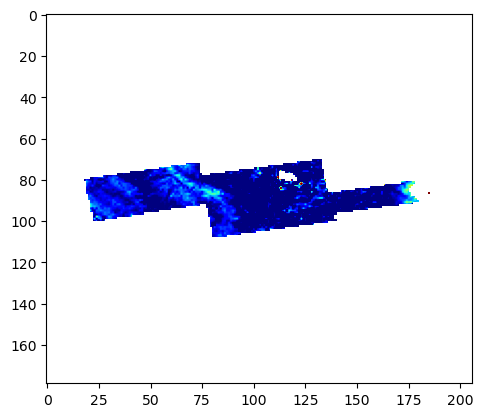

In [55]:
#plt.imshow(combined_rmse,cmap='jet')
plt.imshow(mat_diff,cmap='jet',vmin=-0.01,vmax=0.01)

In [31]:
offset = np.nansum(mat_diff) / np.sum(np.isfinite(mat_diff))
print(f'Average offset between the two frames is:{np.round(offset,4)}m');
flag = np.isfinite(mat_diff);
overlap_length = len(mat_diff[flag])
print(f'No. of pixels in the overlap area:{overlap_length}')

Average offset between the two frames is:-0.01m
No. of pixels in the overlap area:3614


In [33]:

overlap_lons = lons[flag];
overlap_lats = lats[flag];
overlap_RMSE = combined_rmse[flag];
print(np.sum(overlap_RMSE < 0.0008))
flag_RMSE = np.where(overlap_RMSE< 0.0008)[0]
overlap_selected_lons = overlap_lons[flag_RMSE];
overlap_selected_lats = overlap_lats[flag_RMSE];
overlap_vel_diff = mat_diff[flag][flag_RMSE];
print(len(overlap_vel_diff))

[36.23665217 36.23665217 36.23665217 ... 35.60331909 35.60331909
 35.60331909] [-119.53745218 -119.52078552 -119.50411886 ... -120.25411856 -120.23745191
 -120.22078525]


172
172


In [33]:
lats = np.linspace(N, N + length * lat_step, length, endpoint=False);
print(len(lats));
print(lats)

179
[37.40331837 37.38665171 37.36998505 37.35331839 37.33665173 37.31998507
 37.30331841 37.28665175 37.26998509 37.25331843 37.23665177 37.21998511
 37.20331845 37.18665179 37.16998513 37.15331847 37.13665181 37.11998515
 37.10331849 37.08665183 37.06998517 37.05331851 37.03665185 37.01998519
 37.00331853 36.98665187 36.96998521 36.95331855 36.93665189 36.91998523
 36.90331857 36.88665191 36.86998525 36.85331859 36.83665193 36.81998527
 36.80331861 36.78665195 36.76998529 36.75331863 36.73665197 36.71998531
 36.70331865 36.68665199 36.66998533 36.65331867 36.63665201 36.61998535
 36.60331869 36.58665203 36.56998537 36.55331871 36.53665205 36.51998539
 36.50331873 36.48665207 36.46998541 36.45331875 36.43665209 36.41998543
 36.40331877 36.38665211 36.36998545 36.35331879 36.33665213 36.31998547
 36.30331881 36.28665215 36.26998549 36.25331883 36.23665217 36.21998551
 36.20331885 36.18665219 36.16998553 36.15331887 36.13665221 36.11998555
 36.10331889 36.08665223 36.06998557 36.0533189

In [107]:
def get_lat_los(insar_metadata):
    length,width = int(insar_metadata['LENGTH']),int(insar_metadata['WIDTH']) ;
    X_FIRST = round(float(insar_metadata['X_FIRST']),4);
    X_STEP = round(float(insar_metadata['X_STEP']),4);
    X_LAST = round(X_FIRST+width*float(insar_metadata['X_STEP']),4);
    
    Y_FIRST = round(float(insar_metadata['Y_FIRST']),4);
    Y_STEP = round(float(insar_metadata['Y_STEP']),4);
    Y_LAST = round(Y_FIRST+length*float(insar_metadata['Y_STEP']),4);
    lons = np.linspace(X_FIRST, X_LAST, width, endpoint=False)
    lats = np.linspace(Y_FIRST, Y_LAST, length, endpoint=False)
    
    return lons,lats

insar_velocity1,insar_metadata1 = readfile.read(r'C:\Users\bvarugu\Documents\Concord\Asc\velocity_refP725_msk_20alks_20rlks.h5', datasetName='velocity');

(S1,N1,W1,E1) = ut.four_corners(insar_metadata1)
start_date1 = insar_metadata1.get('START_DATE', None)
end_date1 = insar_metadata1.get('END_DATE', None)
coord1 = ut.coordinate(insar_metadata1)
lons1,lats1 = get_lat_los(insar_metadata1)

insar_velocity2,insar_metadata2 = readfile.read(r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\velocity_refMRRY_msk_20alks_20rlks.h5', datasetName='velocity');
(S2,N2,W2,E2) = ut.four_corners(insar_metadata2)
start_date2 = insar_metadata2.get('START_DATE', None)
end_date2 = insar_metadata2.get('END_DATE', None)
coord2 = ut.coordinate(insar_metadata2);
lons2,lats2 = get_lat_los(insar_metadata2);

print('calculate corners of output matrix')
W, E = max(W1, W2), min(E1, E2)
S, N = max(S1, S2), min(N1, N2)
print(W,E,S,N)

calculate corners of output matrix
-121.390784777 -118.504119265 35.586652432 36.24165217


In [103]:
# Create coordinate grids
coords1 = np.array([(lat, lon) for lat in lats1 for lon in lons1])
coords2 = np.array([(lat, lon) for lat in lats2 for lon in lons2])

# Round to desired precision for matching
precision = 4
coords1 = np.round(coords1, precision)
coords2 = np.round(coords2, precision)

# Find overlapping coordinates using sorting
# Convert to unique strings for efficient matching
coords1_str = np.array(["{:.4f}_{:.4f}".format(lat, lon) for lat, lon in coords1])
coords2_str = np.array(["{:.4f}_{:.4f}".format(lat, lon) for lat, lon in coords2])

# Get unique overlaps
overlaps = np.intersect1d(coords1_str, coords2_str)

# Find indices of overlaps in the original arrays
indices1 = np.nonzero(np.isin(coords1_str, overlaps))[0]
indices2 = np.nonzero(np.isin(coords2_str, overlaps))[0]

print("Indices in Raster 1:", indices1)
print("Indices in Raster 2:", indices2)

Indices in Raster 1: []
Indices in Raster 2: []
